In [1]:
import os
import sys
import pdb
import copy
import glob
import warnings
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.util as cutil
import metpy.constants as const
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib import colors
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.transforms as mtransforms
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.append(os.path.abspath("/global/homes/j/jhollo/repos/climate_util"))
from PyTEMDiags import sph_zonal_averager
import climate_toolbox as ctb
import artist_utils as au

# ---------- matplotlib settings

mpl.rcParams.update(mpl.rcParamsDefault)

SMALL_SIZE  = 9
MEDIUM_SIZE = 11
BIG_SIZE    = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

params = {'text.usetex': False, 'mathtext.fontset': 'stixsans'}
plt.rcParams.update(params)
print('done')

done


In [2]:
# ==================================
# ========= read data ==============

data_dest = '/pscratch/sd/j/jhollo/tmp'

timesel = slice(170, 180+40)
latsel = slice(-5, 35)

print('reading ensemble...')
#ens_members = sorted(glob.glob('/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members/ens*/*h2*.nc'))
ens_members = sorted(glob.glob('/global/cfs/cdirs/m4014/data/HSW/outputs/release_011423/netcdf/ens_members/ens*/*h0*06-30*.nc'))
ens_members = [xr.open_dataset(mem) for mem in ens_members]
#ens_members = [mem.assign_coords(time = ctb.time2day(mem['time'])).sel(time=timesel) for mem in ens_members]
ens_members = [mem.assign_coords(time = ctb.time2day(mem['time'])+180).sel(time=timesel) for mem in ens_members]

datlat  = ens_members[0]['lat']
lat     = np.linspace(-90, 90, 181)
lev     = ens_members[0]['lev']
time    = ens_members[0]['time']
weights = xr.DataArray(np.cos(np.deg2rad(lat)), coords={'lat':lat}).sel(lat=latsel)

print('getting ash...')
ash_q_mems  = [mem['ASH'] for mem in ens_members]
ash_colmass = [(mem['ASH'] * mem['AIR_MASS']) * 1e-9 for mem in ens_members]
ash_mass    = ash_colmass[0].sum(dim=('ncol', 'lev'))
print('getting sulf...')
sulf_q_mems  = [mem['SULFATE'] for mem in ens_members]
sulf_colmass = [(mem['SULFATE'] * mem['AIR_MASS']) * 1e-9 for mem in ens_members]
sulf_mass    = sulf_colmass[0].sum(dim=('ncol', 'lev'))

print('taking ash zonal means...')
zm     = sph_zonal_averager(datlat, lat, L=70, debug=False)
zm.sph_compute_matrices()
ash_mems   = [zm.sph_zonal_mean(mem.T).T for mem in ash_colmass]
ash_q_mems = [zm.sph_zonal_mean(mem.T).T for mem in ash_q_mems]
print('taking ash meridional means...')
ash_q_mems = [mem.sel(lat=latsel).weighted(weights) for mem in ash_q_mems]
ash_q_mems = [mem.mean('lat') for mem in ash_q_mems]
ash_mems   = [mem.sel(lat=latsel).weighted(weights) for mem in ash_mems]
ash_mems   = [mem.mean('lat') for mem in ash_mems]
print('getting ensemble mean ash...')
ash_q_em = xr.zeros_like(ash_q_mems[0])
for i in range(len(ash_q_mems)):
    ash_q_em = ash_q_em + ash_q_mems[i]
ash_q_em = ash_q_em / len(ash_q_mems)
ash_em = xr.zeros_like(ash_mems[0])
for i in range(len(ash_mems)):
    ash_em = ash_em + ash_mems[i]
ash_em = ash_em / len(ash_mems)

print('taking sulfate zonal means...')
sulf_mems   = [zm.sph_zonal_mean(mem.T).T for mem in sulf_colmass]
sulf_q_mems = [zm.sph_zonal_mean(mem.T).T for mem in sulf_q_mems]
print('taking sulfate meridional means...')
sulf_mems   = [mem.sel(lat=latsel).weighted(weights) for mem in sulf_mems]
sulf_mems   = [mem.mean('lat') for mem in sulf_mems]
sulf_q_mems = [mem.sel(lat=latsel).weighted(weights) for mem in sulf_q_mems]
sulf_q_mems = [mem.mean('lat') for mem in sulf_q_mems]
print('getting ensemble mean sulfate...')
sulf_em = xr.zeros_like(sulf_mems[0])
for i in range(len(sulf_mems)):
    sulf_em = sulf_em + sulf_mems[i]
sulf_em = sulf_em / len(sulf_mems)
sulf_q_em = xr.zeros_like(sulf_q_mems[0])
for i in range(len(sulf_q_mems)):
    sulf_q_em = sulf_q_em + sulf_q_mems[i]
sulf_q_em = sulf_q_em / len(sulf_q_mems)

print('done')

print('getting Z3...')
z_mems    = [mem['Z3']/1000 for mem in ens_members]

print('taking Z3 zonal means...')
z_mems    = [zm.sph_zonal_mean(z_mem.T).T for z_mem in z_mems]

print('getting lat subset of Z3 for COM...')
z_mems    = [z_mem.sel(lat=latsel) for z_mem in z_mems]
weights   = weights.sel(lat=latsel)

print('taking Z3 meridional means...')
z_mems    = [z_mem.weighted(weights) for z_mem in z_mems]
z_mems    = [z_mem.mean('lat') for z_mem in z_mems]

print('getting ensemble mean Z3...')
z_em = xr.zeros_like(z_mems[0])
for i in range(len(z_mems)):
    z_em = z_em + z_mems[i]
z_em = z_em / len(z_mems)

print('done')

reading ensemble...
getting ash...
getting sulf...
taking ash zonal means...
taking ash meridional means...
getting ensemble mean ash...
taking sulfate zonal means...
taking sulfate meridional means...
getting ensemble mean sulfate...
done
getting Z3...
taking Z3 zonal means...
getting lat subset of Z3 for COM...
taking Z3 meridional means...
getting ensemble mean Z3...
done


In [3]:
print('getting eruption position...')
erupt_pos = np.interp([14], z_em.mean('time')[::-1], lev[::-1])[0]
erupt_time = 180

COM_levrange = slice(0.1, erupt_pos)
COM_levrange=slice(0.1, 1000)

print('getting ash vertical center of mass...')
num_em  = (ash_em * z_em).sel(lev=COM_levrange).sum(dim='lev')
den_em  = (ash_em).sel(lev=COM_levrange).sum(dim='lev')
COM_ash_em  = num_em / den_em
print('interpolating ash COM to pressure...')
COMp_ash_em = np.interp(COM_ash_em, z_em.mean('time')[::-1], lev[::-1])

print('getting sulfate vertical center of mass...')
num_em  = (sulf_em * z_em).sel(lev=COM_levrange).sum(dim='lev')
den_em  = (sulf_em).sel(lev=COM_levrange).sum(dim='lev')
COM_sulf_em  = num_em / den_em
print('interpolating sulfate COM to pressure...')
COMp_sulf_em = np.interp(COM_sulf_em, z_em.mean('time')[::-1], lev[::-1])

print('done')

getting eruption position...
getting ash vertical center of mass...
interpolating ash COM to pressure...
getting sulfate vertical center of mass...
interpolating sulfate COM to pressure...
done


In [4]:
print('getting ash densities...')

cell_areas_m2 = ens_members[0]['area'] * const.Re.m**2
ash_dens_mems = [(mass*1e9 * 1000).sum('lev') / cell_areas_m2 for mass in ash_colmass]

print('getting ensemble mean ash density...')
ash_dens_em = xr.zeros_like(ash_dens_mems[0])
for i in range(len(ash_dens_mems)):
    ash_dens_em = ash_dens_em + ash_dens_mems[i]
ash_dens_em = ash_dens_em / len(ash_dens_mems)

datlat, datlon = ens_members[0]['lat'], ens_members[0]['lon']

# compute density of removed ash by removal function in g/m^2
ash_R_mems_gm2 = [(np.diff(time)[0] * mass*1e9) * 1000 / cell_areas_m2 for mass in ash_colmass]

print('done')

getting ash densities...
getting ensemble mean ash density...
done


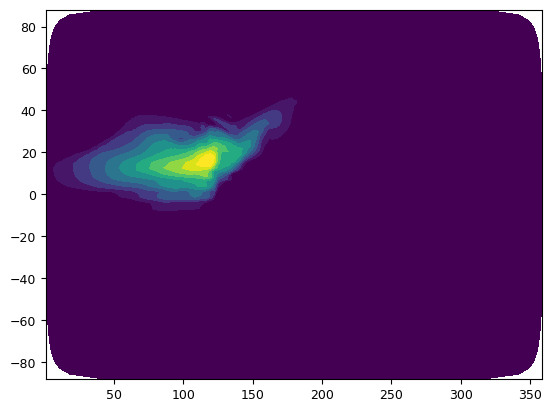

[-5.         -4.40022889 -3.80045778 -3.20068666 -2.60091555 -2.00114444
 -1.40137333 -0.80160222 -0.2018311   0.39794001]


In [5]:
levslice = slice(0, 100)
timeslice = slice(0+180, 50+180)
var = ash_R_mems_gm2[1]
var = var.sel(lev=levslice).sum('lev').sel(time=timeslice).sum('time')

ccc = plt.tricontourf(datlon, datlat, np.log10(var), levels=np.linspace(-5, np.log10(2.5), 10), extend='both')
plt.show()
print(ccc.levels)

/global/homes/j/jhollo/miniconda3/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/global/homes/j/jhollo/miniconda3/lib/python3.9/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/global/homes/j/jhollo/miniconda3/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/tmp/ipykernel_858417/3136563456.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


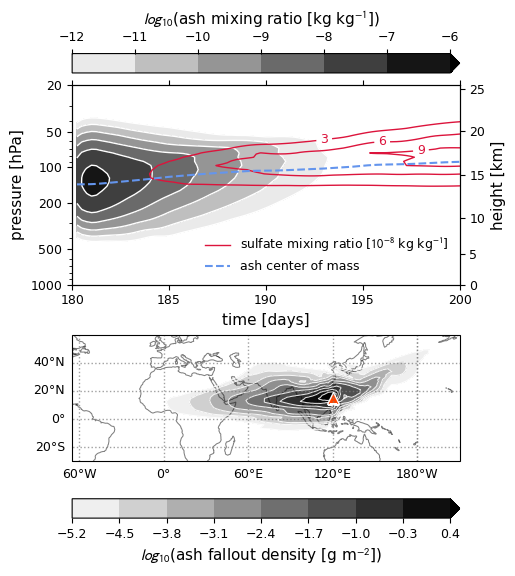

In [11]:
# =============================================
# ===============  plotting  ==================


TIME, LEV = np.meshgrid(time-180, lev) # place eruption at t=0
timelim       = [0, 20]
toff = 180
cmt = time-180

TIME, LEV = np.meshgrid(time, lev) # place eruption at t=0
timelim       = [180, 200]
toff = 0
cmt = time

levlim        = [20, 1000]
timeticks     = np.arange(min(timelim), max(timelim)+5, 5)
levticks      = [1000, 500, 200, 100, 50, 20, 10, 5]

#Slevels   = np.arange(2, 8.1, 3)
Slevels   = np.arange(3, 9.1, 3)
#Slabpos   = [[207.5, 65], [203.5, 45], [198, 40]]
Slabpos   = [[193-toff, 50], [196-toff, 62], [198-toff, 70]]
Slabspace = [0, 0, 0]
Slabrot = [0, 0, 0]

Alevels = np.arange(-12, -5.1, 1)
Acmap = 'gist_yarg'

fig = plt.figure(figsize=(5, 6.5))
gs  = fig.add_gridspec(nrows=2, ncols=3, hspace=0.01, wspace=0) 

# -------------------------------------------

ax  = fig.add_subplot(gs[0:3])

cf = ax.contourf(TIME, LEV, np.log10(ash_q_em).T, cmap=Acmap, levels=Alevels, extend='max')
ax.contour(TIME, LEV, np.log10(ash_q_em).T, colors='w', linewidths=1, levels=Alevels, linestyles='-')

cfs = ax.contour(TIME, LEV, sulf_q_em.T * 1e8, colors='crimson', linestyles='-', levels=Slevels, linewidths=1)
ax.plot([0,0], [0,0], color='crimson', ls='-', lw=1, label=r'sulfate mixing ratio [$10^{-8}$ kg kg$^{-1}$]')

ax.plot(cmt, COMp_ash_em, '--', color='cornflowerblue', lw=1.5, label='ash center of mass')
#ax.plot(time, COMp_ash_em, ':', color='k', lw=1.5, label='ash center of mass')

cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', location='top', extendfrac=0.025,
                    aspect=20, extend='max', extendrect=False)#, format=Tlevels_fmt)
cbar.set_label(r'$log_{10}$(ash mixing ratio [kg kg$^{-1}$])')

for i in range(len(Slabspace)):
    labs = ax.clabel(cfs, inline=True, fontsize=SMALL_SIZE, manual = [Slabpos[i]], 
                      inline_spacing=Slabspace[i], fmt=lambda x: '{:.3g}'.format(x))
for i in range(len(labs)):
    labs[i].set_rotation(Slabrot[i])


ax.set_yscale('log')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y,pos: \
                             ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.set_ylabel('pressure [hPa]')
ax.legend(loc='lower right', ncol=1, fancybox=False, shadow=False, frameon=False, alignment='right')
ax.set_yticks(levticks)
ax.set_ylim(levlim)
ax.invert_yaxis()

ax.set_xticks(timeticks)
ax.set_xlim(timelim)
ax.tick_params(top=True, bottom=True, labeltop=False, labelbottom=True, which='both')
ax.set_xlabel('time [days]')
#ax.xaxis.set_label_position('top')

axz = ax.twinx()
axz.set_yscale('log')
zyticks_z = np.arange(0, 61, 5)
zyticks_p = np.interp(zyticks_z, z_em.mean('time')[::-1], lev[::-1])
axz.set_yticks(zyticks_p, labels=zyticks_z)
axz.set_ylim(levlim)
axz.invert_yaxis()
axz.tick_params(right=False, which='minor')
axz.set_ylabel('height [km]')

# --------------------------------------------------
    
cenlon = 35
data_crs = ccrs.PlateCarree()
projection = ccrs.PlateCarree(central_longitude=cenlon)

ashtimes = np.array([5, 10, 15]) + erupt_time
#extent = [-50, 150, -20,55]
extent = [-65, 210, -30,60]
clalpha = 0.5
cllw = 0.75
aspect = 1.5

#var = ash_dens_em
#var = ash_dens_mems[1]

#var = var.sel(time=10+180)
#var = np.log10(var.sel(time=5+180))
#clevels = np.arange(np.max(var)-1, np.max(var), 0.25)
#var = var.sel(time=slice(0+180,30+180)).sum('time')
#clevels = np.logspace(np.log10(0.001), np.log10(0.01), 6)
#clevels = 10.0**np.array([-4, -3, -2, -1, 0])

#var = (ens_members[1]['ASH']).sel(lev=slice(50, 100)).mean('lev').sel(time=12+180)
#clevels = 6

levslice = slice(0, 100)
timeslice = slice(0+180, 20+180)
var = ash_R_mems_gm2[1]
var = np.log10(var.sel(lev=levslice).sum('lev').sel(time=timeslice).sum('time'))
clevels=np.linspace(-5.25, np.log10(2.5), 9)
clevels = np.arange(-5.2, 0.4, 0.7)

#var, datlon_ = cutil.add_cyclic_point(var, datlon)

ax2  = fig.add_subplot(gs[3:], projection=projection)
cfw = ax2.tricontourf(datlon, datlat, var, cmap=Acmap, levels=clevels, transform=data_crs, extend='max')
ax2.tricontour(datlon, datlat, var, colors='w', levels=clevels, transform=data_crs, linewidths=0.75, linestyles='-', alpha=0.88)
ax2.set_extent(extent, crs=data_crs)
ax2.tick_params(top=False, bottom=True, left=True, right=False, 
                labeltop=False, labelbottom=True, labelleft=True, labelright=False, which='both')
ax2.coastlines(alpha=clalpha, lw=cllw)
#ax2.set_aspect(aspect)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='grey', alpha=0.75, linestyle=':')
gl.xlabels_top = False
#gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': SMALL_SIZE}
gl.ylabel_style = {'size':SMALL_SIZE}

cbar = fig.colorbar(cfw, ax=ax2, orientation='horizontal', location='bottom', extendfrac=0.025,
                    aspect=20, extend='both', extendrect=False)
cbar.set_label(r'$log_{10}$(ash fallout density [g m$^{-2}$])')

ax2.plot([120], [15], '^', color='orangered', ms=8, transform=data_crs, mec='w', mew=1)

# ---------------------------------------------------

plt.tight_layout()
fig.savefig('figs/ash.pdf', dpi=300, bbox_inches='tight')
plt.show()